<a href="https://colab.research.google.com/github/AminaTkh/AlanTuringInstitute_Bias_in_AI/blob/main/Mitigating-Bias-and-Discrimination/Postprocessing_instructions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Post-processing technique: Equalised Odds Post-processing**

The Equalised Odds Post-Processing approach (Hardt et al 2016) flips predictions at random until a desired error rate distribution between the protected group and the rest of the sample is achieved. The steps we will take are outlined below.

1. First, we will calculate Disparate Impact and Statistical Parity Difference metrics for a baseline model with no fairness intervention.
2. We will then apply the Equalised Odds Post-processing method to data used to train a predictive model and observe the results.

# Install Libraries and load data

In [1]:
# install holisticai
!pip install holisticai

import pickle
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from holisticai.bias.mitigation import EqualizedOdds
from holisticai.bias import metrics as bias_metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.4/241.4 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 67.3 MB/s eta 0:00:00


Load the data into a dataframe

In [2]:
# suppress warnings
import warnings
warnings.simplefilter("ignore")

# Load data
from sklearn.datasets import fetch_openml
bunch = fetch_openml(data_id=44270)
df = bunch['frame'].dropna()
df['Ethnicity_White'] = (df['Ethnicity'] == 'White')*1
df['Ethnicity_Black'] = (df['Ethnicity'] == 'Black')*1
df = df.drop(columns = ['Gender', 'Ethnicity'])
df

,Label,0,1,2,3,4,5,6,7,8,...,42,43,44,45,46,47,48,49,Ethnicity_White,Ethnicity_Black
0,1,-0.178832,0.147077,0.775331,-0.427889,0.640818,-0.610427,-1.023371,1.431524,1.459619,...,-0.355889,-0.465837,-2.832634,0.917297,-0.241052,-2.122105,0.253170,0.164617,0,1
1,1,0.092276,0.122023,0.482935,-0.232131,-1.939064,-1.140216,-0.833250,-1.281904,0.228971,...,-1.417751,1.254152,0.631731,1.665469,-0.388293,-0.804782,-0.227182,0.412375,0,0
2,0,-1.703377,-0.962149,-0.785495,-0.633902,-0.334718,-1.555958,0.825006,0.274443,1.448419,...,0.079523,-0.932425,-0.693293,-0.114197,-1.252067,0.834270,-0.463270,0.559294,0,0
4,1,-0.363013,1.264307,1.667603,0.903941,-0.062840,0.680886,0.389930,-0.000803,-0.782676,...,-0.311236,2.447118,1.127650,0.086733,-0.381553,0.209684,0.197809,-0.879914,0,0
5,0,0.152488,-0.731821,-0.167126,-1.193398,1.180502,0.469656,-0.044317,-0.409883,0.625990,...,-0.298833,2.067846,0.304233,-0.160228,1.017770,-1.002570,0.844326,-1.155311,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,0,-1.706395,-0.435942,0.645464,-0.859816,0.914893,-0.022199,-0.424393,-0.976591,0.672857,...,0.181203,0.367494,0.162101,-1.688369,-1.151553,0.777658,-1.044357,-0.074341,0,0
9995,1,-0.057075,1.791513,-1.065756,-0.783341,-0.559215,1.042646,-1.154058,1.094753,1.968674,...,0.021583,1.718576,1.171804,0.430075,3.340726,1.349216,1.481516,0.070563,0,0
9996,1,0.582066,0.086788,0.167259,-1.672798,1.537135,-1.113315,0.222907,-1.743083,-0.086986,...,-0.072920,-1.841719,-0.807065,-0.793955,-1.098300,-1.474154,-0.828826,-0.891166,0,1
9997,0,-1.355098,-0.321228,-0.204290,0.498632,1.634130,0.847070,-0.552140,-1.614727,2.337347,...,-1.781911,0.275032,0.690859,0.666878,0.644440,0.127891,1.277781,-0.744428,1,0


# Run a baseline predictive model without applying post-processing
First we will build a Logistic Regression classifier and observe some baseline results, using the original data without Post-processing.

Set up variables for the privileged and unprivileged groups. In this example we will assign 'Ethnicity_White' as our privileged group and Black as the unpriviledged group.

Train a Logistic Regression model with 10 fold stratified cross validation. Compute performance metrics (Accuracy, Precision, Recall and F1 Score) and fairness metrics (Equalized Odds Difference, False Negative Rate Difference, Statistical Parity Difference).


In [3]:
# Instantiate the classifier (this code is ready to run, there are no gaps to fill)
model = LogisticRegression(random_state=10, solver="lbfgs", penalty="none")

# instantiate the cross-validation scheme
mv = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)

# setup the performance metrics to be computed
perf_metrics = {"Accuracy": metrics.accuracy_score,
                "Precision": metrics.precision_score,
                "Recall": metrics.recall_score,
                "F1-Score": metrics.f1_score,
                }

In [4]:
# Train a logistic regression classifier on the dataset (this code is ready to run, there are no gaps to fill)
k, i = True, 1

# instantiating X
X = df.drop(columns=["Label"])

# instantiating the target variable
y = df['Label']

for (train, test) in mv.split(X, y):

    # instantiating X
    X_train = X.iloc[train].copy()

    # instantiating y
    y_train = y.iloc[train].copy()

    # fit model
    model.fit(X_train, y_train)

    # X_test
    X_test = X.iloc[test]

    # set up vectors
    group_a = X_test.Ethnicity_Black == 1
    group_b = X_test.Ethnicity_White == 1
    y_pred = model.predict(X_test)
    y_true = y.iloc[test].values.ravel()
    params = [group_a, group_b, y_pred]

    # compute performance metrics
    metric_list = []
    for pf in perf_metrics.keys():
            metric_list += [[pf, perf_metrics[pf](y_true, y_pred)]]

    # Compute fairness metrics
    metric_list += [['Statistical Parity Difference', bias_metrics.statistical_parity(group_a, group_b, y_pred)]]
    metric_list += [['Disparate Impact', bias_metrics.disparate_impact(group_a, group_b, y_pred)]]
    metric_list += [['Equalized Odds Difference', bias_metrics.average_odds_diff(group_a, group_b, y_pred,y_true)]]
    metric_list += [['False Negative Rate Difference', bias_metrics.false_negative_rate_diff(group_a, group_b, y_pred,y_true)]]

    # concatenate results
    df_m = pd.DataFrame(metric_list, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics_orig = df_m.copy()
        k=0
    else:
        df_metrics_orig = pd.concat([df_metrics_orig, df_m.copy()], axis=0, ignore_index=True)

df_metrics_orig

,Metric,Value,Fold
0,Accuracy,0.724059,1
1,Precision,0.658363,1
2,Recall,0.558912,1
3,F1-Score,0.604575,1
4,Statistical Parity Difference,-0.043950,1
...,...,...,...
75,F1-Score,0.564706,10
76,Statistical Parity Difference,-0.065582,10
77,Disparate Impact,0.800300,10
78,Equalized Odds Difference,-0.025757,10


In [6]:
# Display metrics
metrics_orig = df_metrics_orig.pivot_table(index = 'Metric', values = 'Value', aggfunc = ['mean', 'std'])
metrics_orig

,mean,std
,Value,Value
Metric,,
Accuracy,0.704631,0.017170
Disparate Impact,0.796023,0.129578
Equalized Odds Difference,-0.068091,0.059287
F1-Score,0.577052,0.025183
False Negative Rate Difference,0.097872,0.088735
Precision,0.627431,0.026669
Recall,0.534339,0.025865
Statistical Parity Difference,-0.076401,0.053235


# Apply Equalised Odds Post-processing to the predictive model

Amend your Logistic Regression routine above to apply [Equalized Odds](https://holisticai.readthedocs.io/en/latest/generated/holisticai.bias.mitigation.EqualizedOdds.html#holisticai.bias.mitigation.EqualizedOdds) Post-Processing to each fold of training data.  Compute performance metrics (Accuracy, Precision, Recall and F1 Score) and fairness metrics (Equalized Odds Difference, False Negative Rate Difference, Statistical Parity Difference)

In [7]:

k, i = True, 1

# instantiating X
X = df.drop(columns=["Label"])

# instantiating the target variable
y = df['Label']

for (train, test) in mv.split(X, y):

    # Set up the data
    X_train = X.iloc[train].copy()
    y_train = y.iloc[train].copy()

    # fit model
    model = model.fit(X_train, y_train)

    # get predictions in the test set
    X_test = X.iloc[test].copy()
    y_test = y.iloc[test].copy()
    ypred_prob = model.predict_proba(X_test).ravel()[1::2] # get probabilities
    ypred_class = model.predict(X_test)

    # fit post-processing using results from 60% of the test set
    test_pct = 0.4
    n = int(len(y_test))
    n_2 = int(n* (1-test_pct))
    indices = np.random.permutation(n)
    pp_indices = indices[:n_2]
    test_indices = indices[n_2:]

    # set up data
    group_a = X_test.reset_index().Ethnicity_Black == 1
    group_b = X_test.reset_index().Ethnicity_White == 1
    y_train_pp = np.array(y_test)[pp_indices]
    y_pred_train = np.array(ypred_class)[pp_indices]
    group_a_train = np.array(group_a)[pp_indices]
    group_b_train = np.array(group_b)[pp_indices]
    y_pred_test = np.array(ypred_class)[test_indices]
    group_a_test = group_a[test_indices]
    group_b_test = group_b[test_indices]
    y_true_test = np.array(y_test)[test_indices]

    # Use eq to post-process predictions on the other 40% of the test set
    eq = EqualizedOdds(solver='highs', seed=42)

    # fit it
    eq.fit(y_train_pp, y_pred_train, group_a_train, group_b_train)

    # transform
    d = eq.transform(y_pred_test, group_a_test, group_b_test)

    # get new labels
    y_pred = d['y_pred']


    # compute performance metrics
    metric_list = []
    for pf in perf_metrics.keys():
            metric_list += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_class.ravel())]]

    # Compute fairness metrics
    metric_list += [['Statistical Parity Difference', bias_metrics.statistical_parity(group_a_test, group_b_test, y_pred)]]
    metric_list += [['Disparate Impact', bias_metrics.disparate_impact(group_a_test, group_b_test, y_pred)]]
    metric_list += [['Equalized Odds Difference', bias_metrics.average_odds_diff(group_a_test, group_b_test, y_pred ,y_true_test)]]
    metric_list += [['False Negative Rate Difference', bias_metrics.false_negative_rate_diff(group_a_test, group_b_test, y_pred ,y_true_test)]]

    # concatenate results
    df_m = pd.DataFrame(metric_list, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics = df_m.copy()
        k=0
    else:
        df_metrics = pd.concat([df_metrics, df_m.copy()], axis=0, ignore_index=True)

In [8]:
# Display metrics

metrics_pp = df_metrics.pivot_table(index = 'Metric', values = 'Value', aggfunc = ['mean', 'std'])
metrics_pp

,mean,std
,Value,Value
Metric,,
Accuracy,0.704631,0.017170
Disparate Impact,0.999367,0.152830
Equalized Odds Difference,0.016988,0.041804
F1-Score,0.577052,0.025183
False Negative Rate Difference,-0.016961,0.150303
Precision,0.627431,0.026669
Recall,0.534339,0.025865
Statistical Parity Difference,-0.000787,0.044953


# Present results to show the effectiveness of the Post-processing method

Present graphs (bar charts work well) to show how each performance and fairness metric differs for the baseline model compared with the application of Post-processing. Show the target line for each metric on the graph.

In [9]:
# Present graphs to show each performance and fairness metrics

table = pd.concat([metrics_orig, metrics_pp], axis=1).iloc[:,[0,2]]
table.columns = ['Baseline', 'PostProcessing']
table

,Baseline,PostProcessing
Metric,,
Accuracy,0.704631,0.704631
Disparate Impact,0.796023,0.999367
Equalized Odds Difference,-0.068091,0.016988
F1-Score,0.577052,0.577052
False Negative Rate Difference,0.097872,-0.016961
Precision,0.627431,0.627431
Recall,0.534339,0.534339
Statistical Parity Difference,-0.076401,-0.000787


In [10]:
table1 = table.drop(columns=['PostProcessing']).copy()
table1 = table1.rename(columns= {'Baseline':'Value'})
table1['Method'] = 'Original'
table2 = table.drop(columns=['Baseline']).copy()
table2 = table2.rename(columns= {'PostProcessing':'Value'})
table2['Method'] = 'PostProcessing'
table_res = pd.concat([table1, table2], axis = 0)
table_res

,Value,Method
Metric,,
Accuracy,0.704631,Original
Disparate Impact,0.796023,Original
Equalized Odds Difference,-0.068091,Original
F1-Score,0.577052,Original
False Negative Rate Difference,0.097872,Original
Precision,0.627431,Original
Recall,0.534339,Original
Statistical Parity Difference,-0.076401,Original
Accuracy,0.704631,PostProcessing


<Axes: xlabel='Metric', ylabel='Value'>

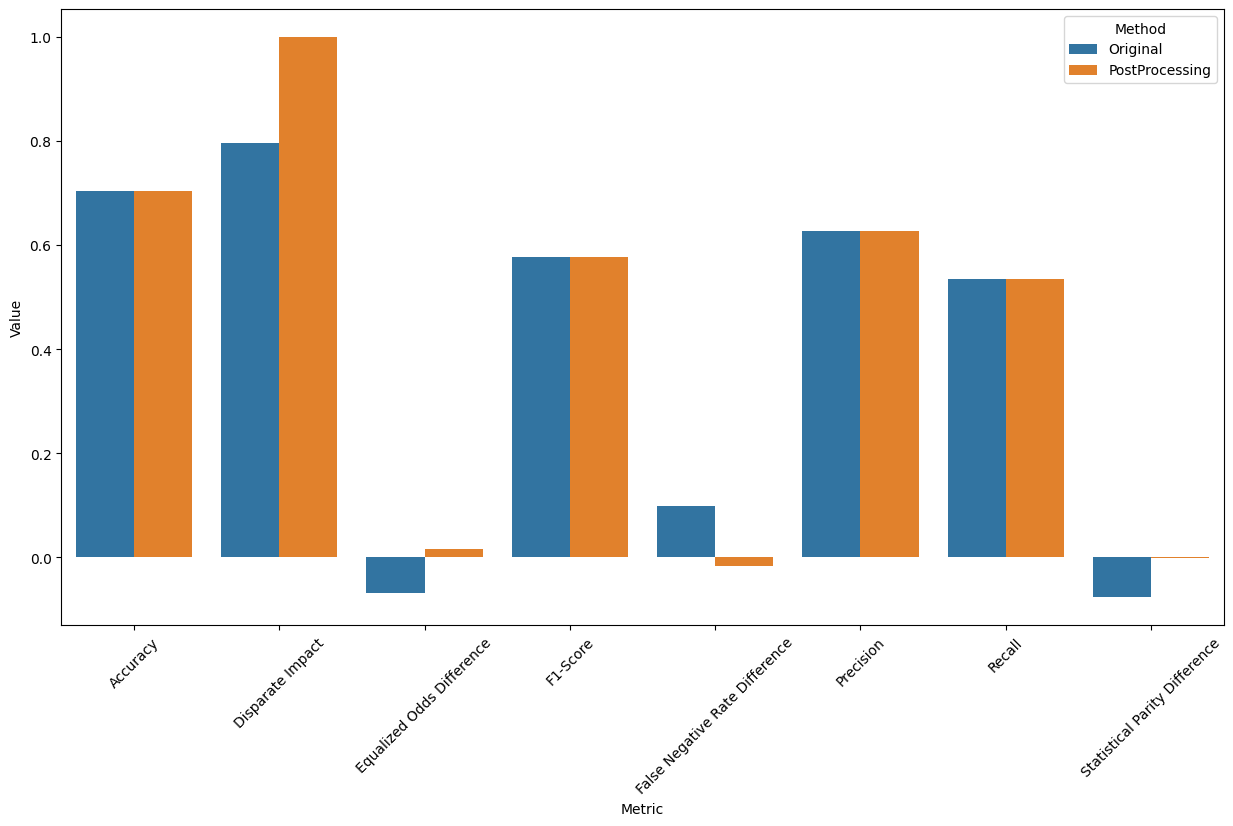

In [11]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.barplot(data=table_res, x=table_res.index, y="Value", hue='Method')
